In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from matplotlib.patches import Patch
import os
import re
from matplotlib.colors import to_rgb
from matplotlib.ticker import FuncFormatter
from matplotlib import font_manager as fm

#from plot_ts import plot_func_ts


In [9]:
Comparison_Pool = ['CNN','OmniAnomaly', 'USAD', 'AutoEncoder', 'KMeansAD', 'CBLOF', 'OCSVM', 'FITS', 'LOF','HBOS','MCD',
                    'AnomalyTransformer','KNN',  'TimesNet', 'TranAD', 'IForest', 'PCA', "RobustPCA", 'LSTMAD'] 

DNN_pool = ['USAD','CNN', 'OmniAnomaly', 'FITS', 'TimesNet', 'TranAD', 'LSTMAD', 'AnomalyTransformer']

Streaming_Pool = ['LODA', 'RRCF', 'HSTree', 'RSHash', 'MemStream', 'MCOD', 'LEAP', 'xStream', 'SWKNN', 'SDOstream']



In [ ]:
df_AUC_PR_off = pd.read_csv('benchmark_eval_results/static/AUC-PR.csv')
df_AUC_PR_off.head()

df_AUC_PR_on = pd.read_csv('benchmark_eval_results/online/AUC-PR.csv')
df_AUC_PR_stream = pd.read_csv('benchmark_eval_results/streaming/AUC-PR.csv')

df_AUC_PR_full = pd.merge(df_AUC_PR_on, df_AUC_PR_stream, on='file')



meta_feature_df = pd.read_csv('../meta_features.csv')
mean_throughput_df = pd.read_csv('benchmark_eval_results/time/mean_throughput.csv')
merged_throughput_df = pd.merge(
    meta_feature_df,
    mean_throughput_df,
    left_on='file_name',
    right_on='file',
    how='inner'
)


merged_throughput_df = merged_throughput_df[['file',  'CNN', 'OmniAnomaly', 'PCA', 'USAD', 'AutoEncoder', 'KMeansAD',
       'CBLOF', 'OCSVM', 'RobustPCA', 'FITS', 'IForest', 'HBOS', 'TimesNet',
       'KNN', 'TranAD', 'LOF', 'AnomalyTransformer', 'MCD', 'LODA','LSTMAD', 'RRCF',
       'RSHash', 'HSTree', 'MemStream', 'LEAP', 'MCOD', 'SWKNN', 'xStream',
       'SDOstream', 'features']]




In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

def plot_aucpr_online_vs_offline(
    off_df: pd.DataFrame,
    on_df: pd.DataFrame,
    model: str,
    ax=None,
    s=30,
    alpha=0.9,
    axis_mode="fixed",
    **kwargs
):
    # Visualize the performance shift between Static and Online modes.
    # Data points are colored by gain: Green (Online wins), Red (Static wins).
    
    x_arr = off_df[model].to_numpy(dtype=float)
    y_arr = on_df[model].to_numpy(dtype=float)
    
    mask = ~np.isnan(x_arr) & ~np.isnan(y_arr)
    x_arr, y_arr = x_arr[mask], y_arr[mask]

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    xmin, xmax = (0.0, 1.0)

    if x_arr.size > 0:
        gain = y_arr - x_arr

        cmap_gain = LinearSegmentedColormap.from_list(
            "gain_loss", ["#8B0000", "#FFFFFF", "#006400"]
        )
        norm_gain = TwoSlopeNorm(vmin=-1.0, vcenter=0.0, vmax=1.0)
        
        ax.scatter(
            x_arr, y_arr, 
            s=s, 
            c=gain, 
            cmap=cmap_gain, 
            norm=norm_gain, 
            edgecolor="black", 
            linewidth=0.3,
            alpha=alpha,
            zorder=3
        )

    # Add diagonal y=x reference and shaded background zones
    ax.plot([xmin, xmax], [xmin, xmax], color="red", linestyle="--", linewidth=1, zorder=4)
    
    x_fill = np.linspace(xmin, xmax, 100)
    ax.fill_between(x_fill, x_fill, xmax, color="#90EE90", alpha=0.1, zorder=0) 
    ax.fill_between(x_fill, xmin, x_fill, color="#F08080", alpha=0.1, zorder=0) 

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)
    ax.set_aspect('equal')
    
    display_map = {
        "OmniAnomaly": "OA", "AutoEncoder": "AE", "TimesNet": "TN", "TranAD": "TrAD",
        "OCSVM": "SVM", "LSTMAD":"LSTM", "RobustPCA": "RPCA", "AnomalyTransformer": "AT",
        "KMeansAD": "KMAD", "SDOstream":"SDOs", "MemStream": "MemS", "xStream" : 'xS',
        'IForest': 'IF', 'RSHash': 'RSH', 'HSTree': 'HST', "SWKNN": 'SKNN'
    }
    ax.set_title(display_map.get(model, model), fontsize=18)#, fontweight='bold')

    return ax

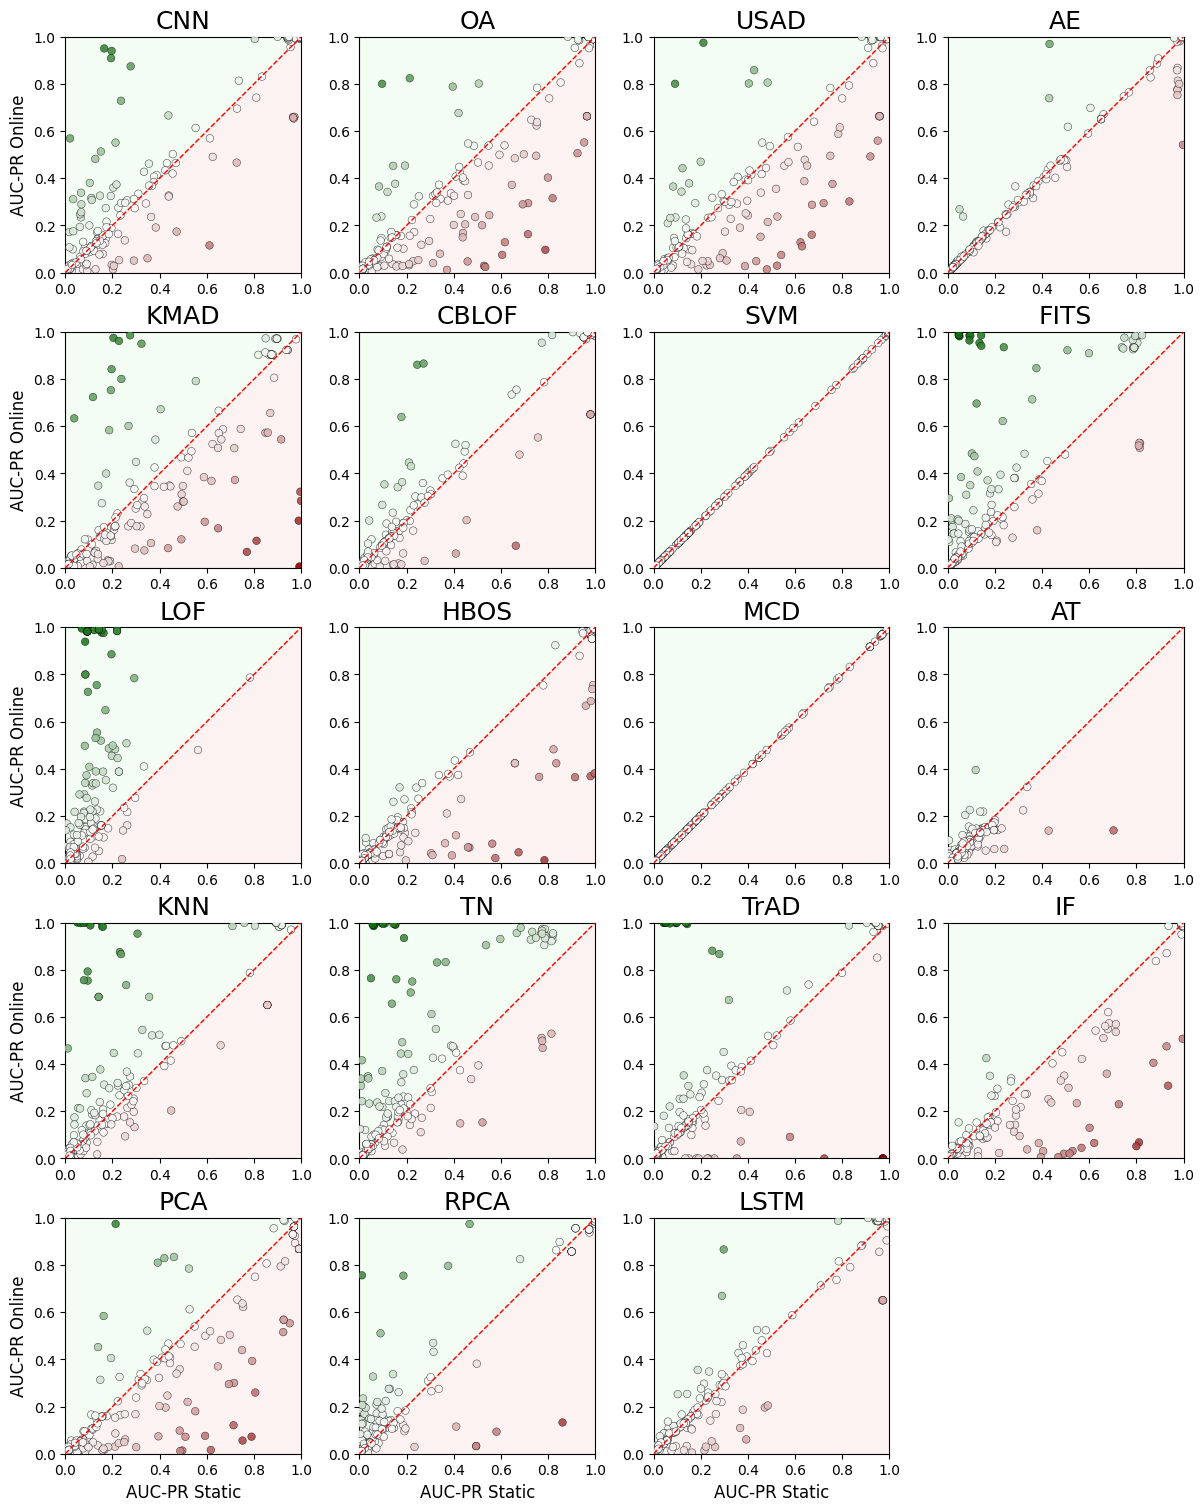

In [12]:
nrows, ncols = 5,4
nplots = nrows * ncols
models_to_plot = list(Comparison_Pool)[:nplots]

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 15), constrained_layout=True) 
axes = np.array(axes).reshape(nrows, ncols)

for i, model in enumerate(models_to_plot):
    r = i // ncols
    c = i % ncols
    ax = axes[r, c]

    plot_aucpr_online_vs_offline(off_df=df_AUC_PR_off,
        on_df=df_AUC_PR_on,

    model =model,
    ax=ax,
    s=30,
    alpha=0.9,
    )

for j in range(len(models_to_plot), nplots):
    r = j // ncols
    c = j % ncols
    axes[r, c].axis("off")

for ax in axes[-1, :]:
    ax.set_xlabel("AUC-PR Static", fontsize=12)
    # apply_font_to_axes(ax, family_name)
for ax in axes[:, 0]:
    ax.set_ylabel("AUC-PR Online", fontsize=12)
    # apply_font_to_axes(ax, family_name)


# os.makedirs("plots/article/", exist_ok=True)
# plt.savefig("plots/article/annex_sta_vs_on.pdf",format="pdf", 
#     bbox_inches="tight",  
#     transparent=True      
# )

# fig.savefig("grid_aucpr.png", dpi=200) 
plt.show()





In [ ]:

# file = "136_OPPORTUNITY_id_8_HumanActivity_tr_1495_1st_1595.csv"
# file_name = file.split('.')[0]
# df = pd.read_csv(f'../../TSBAD/Datasets/TSB-AD-M/{file}').dropna()
# data = df.iloc[:, 0:-1].values.astype(float)
# features = data.shape[1]
# i=153
# data = df.iloc[:, i].values.astype(float)
# label = df['Label'].astype(int).to_numpy()
# fig_ts = plot_func_ts(data, label, f'{file_name} feature {df.columns[i]}', tr = 1495)
# fig_ts.show()

# # for i in range(features): #np.linspace(135, 160, dtype=int): #range(features)
# #     data = df.iloc[:, i].values.astype(float)
# #     label = df['Label'].astype(int).to_numpy()
# #     fig_ts = plot_func_ts(data, label, f'{file_name} feature {df.columns[i]}')
# #     fig_ts.show()

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MAIN_DRIFTS = ["continuous", "change_point", "random_walk", "periodic"]

def normalize_tokens(type_str):
    tokens = [t.strip().lower() for t in type_str.split()]
    normalized = []
    for t in tokens:
        if t in MAIN_DRIFTS:
            normalized.append(t)
        elif "periodic" in t:
            normalized.append("periodic")
        elif "change" in t:
            normalized.append("change_point")
    return list(sorted(set(normalized)))

def compute_drift_list(row):
    if row["CD"] == 0:
        return ["no_drift"]
    return normalize_tokens(row["type"])

def explode_on_drift(df):
    # Expand rows so that files with multiple drift types are represented individually
    df = df.copy()
    df["drift_list"] = df["file"].apply(lambda f: DRIFT_LISTS.get(f, ["no_drift"]))
    return df.explode("drift_list").rename(columns={"drift_list": "drift_type"})

def mean_per_drift(df, model_cols):
    row_mean = df[model_cols].mean(axis=1, skipna=True)
    return df.assign(row_mean=row_mean).groupby('drift_type')['row_mean'].mean()



def draw_single_model_spider(ax, df_on, model_name, color_on='#1f77b4'):
    # Plot a radar chart for a specific model's performance across different drift types
   
    df_on_exp = explode_on_drift(df_on)

    mean_on = df_on_exp.groupby('drift_type')[model_name].mean()
    values_on = mean_on.values
    labels = mean_on.index.tolist()

    N = len(labels)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]
    rad_on = np.concatenate([values_on, values_on[:1]])

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.plot(angles, rad_on, color=color_on, linewidth=1.5, label='Streaming')
    ax.fill(angles, rad_on, color=color_on, alpha=0.1)

    ax.set_ylim(0, 0.5)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=7) 
    ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5'])
    ax.set_title(model_name, fontsize=13, pad=10)

C:\Users\d66285\AppData\Local\Temp\ipykernel_22744\3249822831.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5'])
C:\Users\d66285\AppData\Local\Temp\ipykernel_22744\3249822831.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5'])
C:\Users\d66285\AppData\Local\Temp\ipykernel_22744\3249822831.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5'])
C:\Users\d66285\AppData\Local\Temp\ipykernel_22744\3249822831.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0.1', '0.2', '0

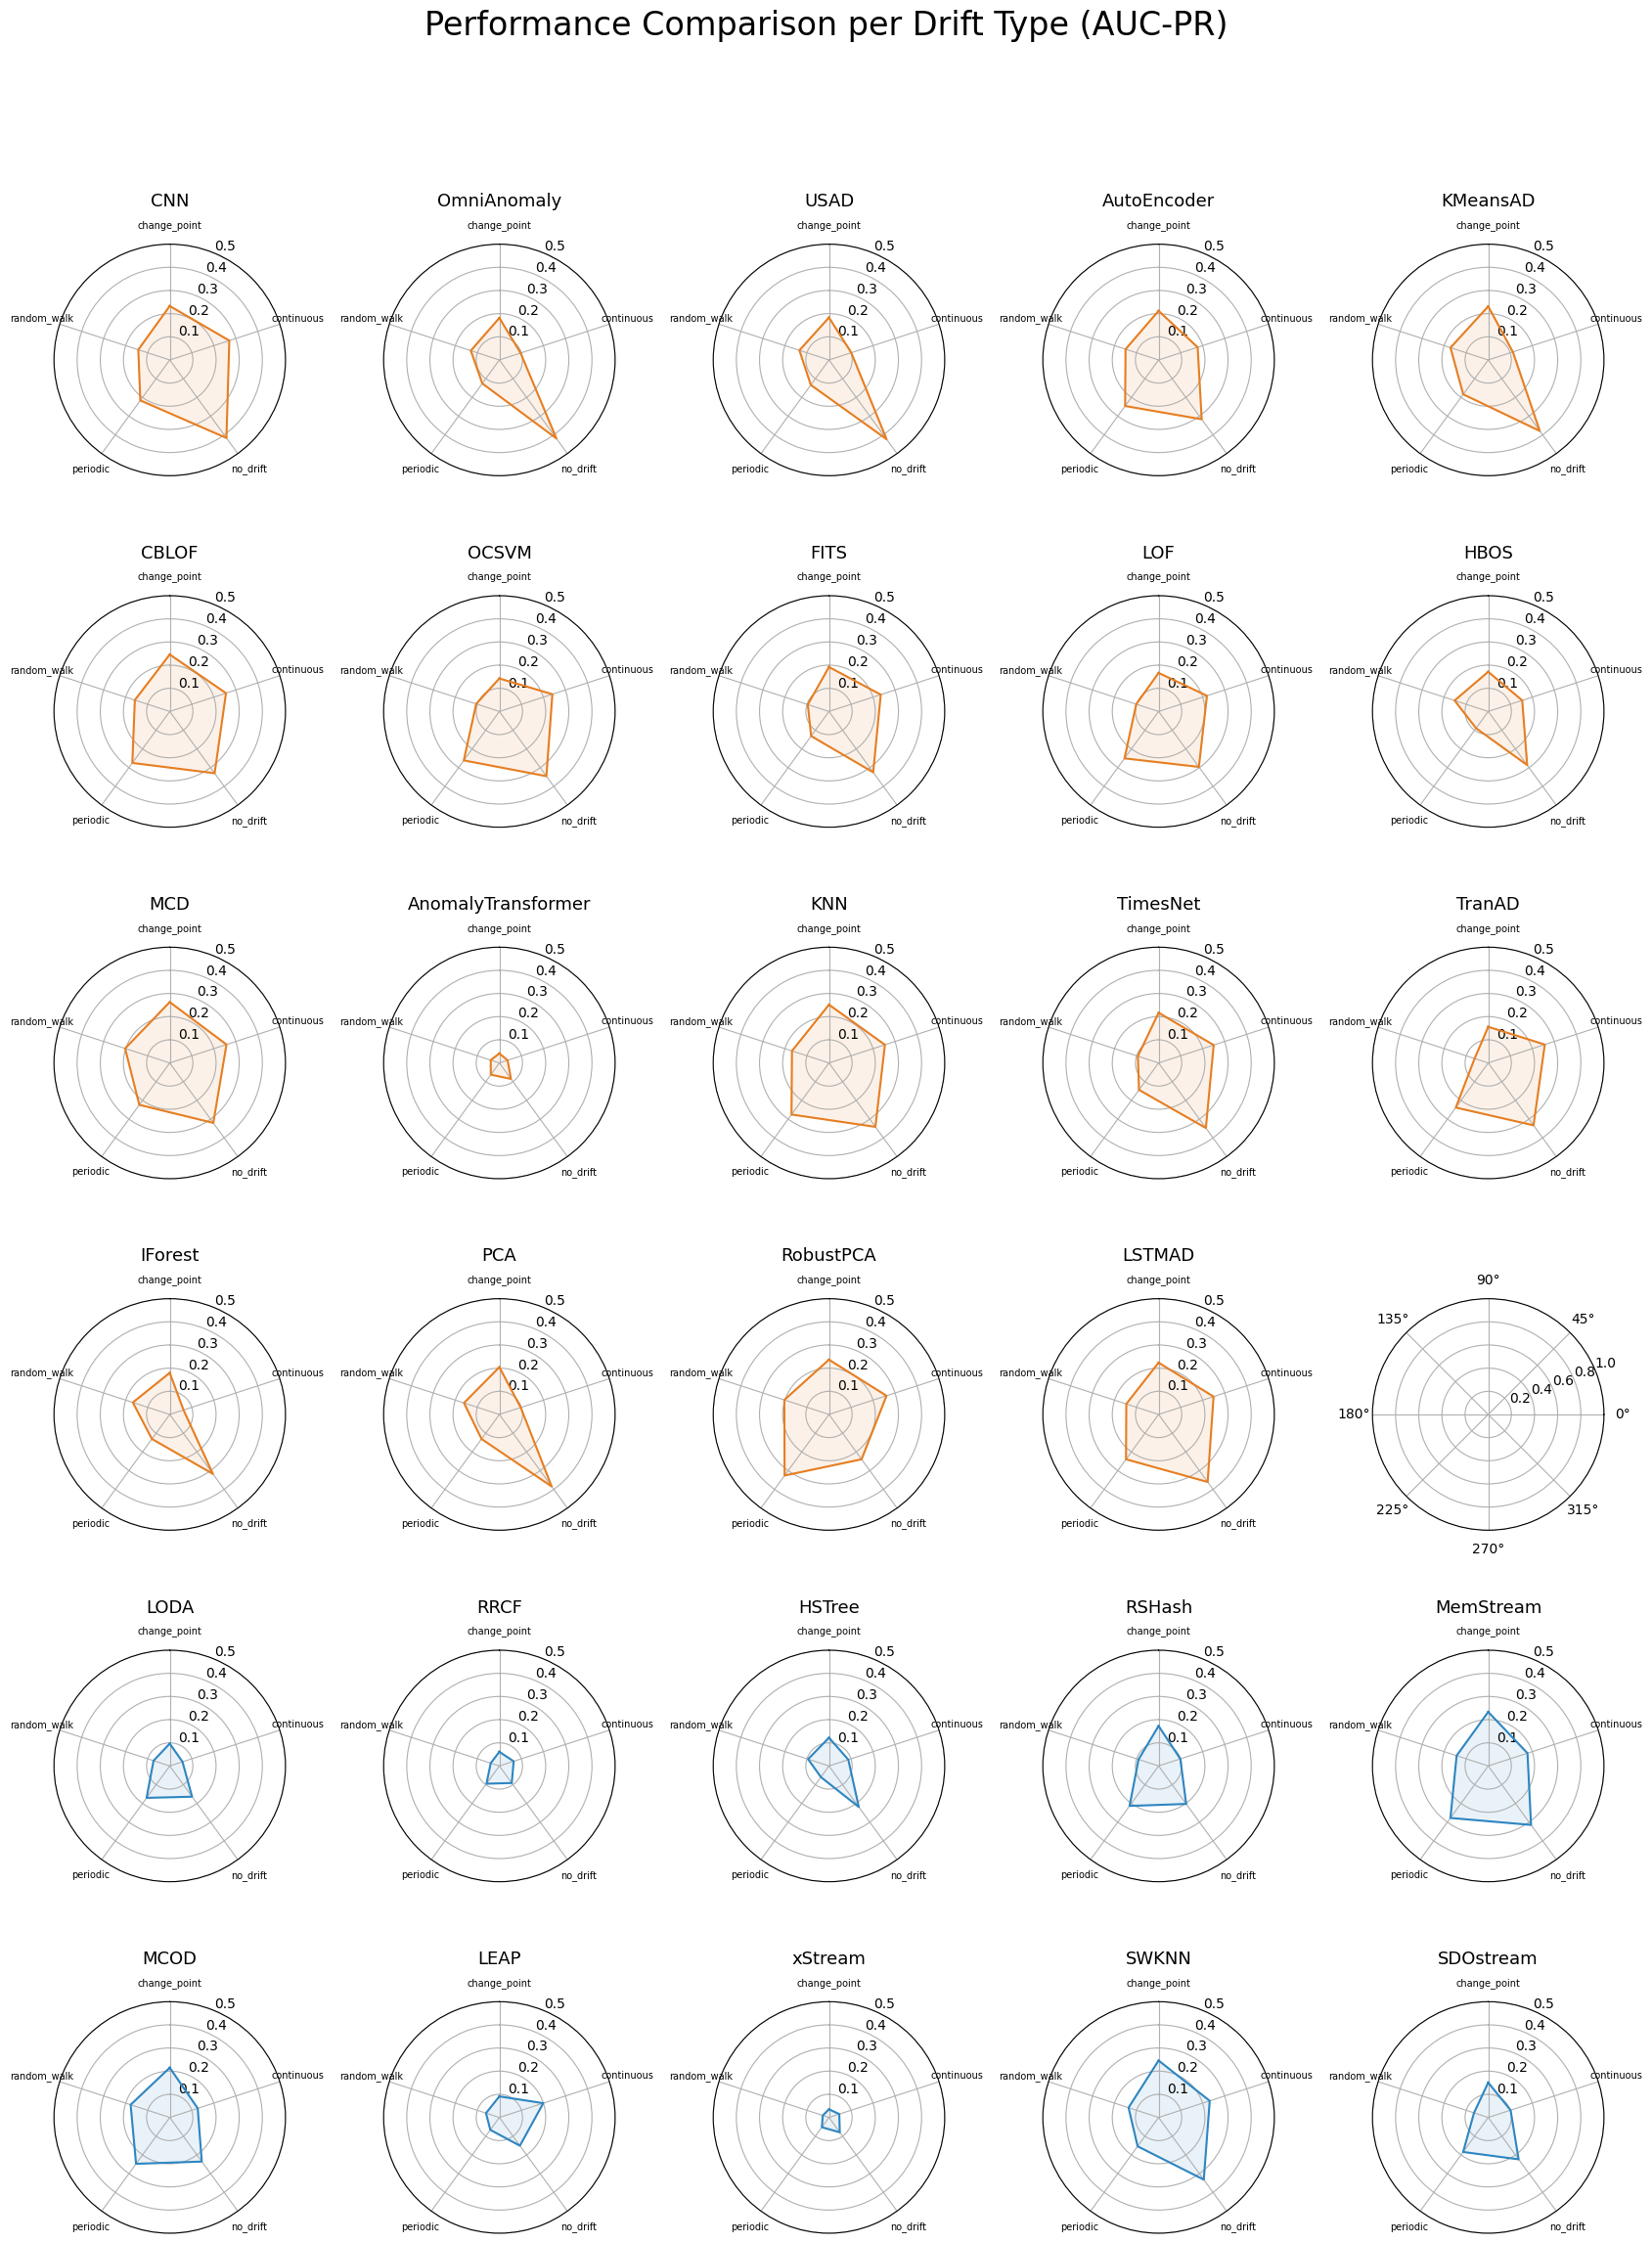

In [7]:
# Ajout de la liste des drifts
cd_df = pd.read_csv('benchmark_eval_results/analysis/CD.csv')
cd_df["drift_list"] = cd_df.apply(compute_drift_list, axis=1)

DRIFT_LISTS = dict(zip(cd_df["file"], cd_df["drift_list"]))


models_to_plot = [m for m in (Comparison_Pool + Streaming_Pool) if m in df_AUC_PR_full.columns]
nrows, ncols = 6, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(17, 22), 
                         subplot_kw=dict(polar=True), 
                         constrained_layout=True)
axes = axes.flatten()

for i, model in enumerate(models_to_plot):
    if i >= len(axes): break

    if model in Comparison_Pool:
        color = '#E67E22'

    else :
        i+=1
        color = '#2E86C1'
    
    draw_single_model_spider(
        ax=axes[i],  
        df_on=df_AUC_PR_full, 
        model_name=model, 
        color_on=color
    )

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

legend_elements = [
    Patch(facecolor='dodgerblue', alpha=0.3, label='Streaming'),
    Patch(facecolor='orange', alpha=0.3, label='Online'),
]
# fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.02),
#            ncol=2, frameon=False, fontsize=20)

plt.suptitle("Performance Comparison per Drift Type (AUC-PR)", fontsize=24, y=1.05)

# apply_font_to_axes(plt, family_name)
plt.tight_layout()

# os.makedirs("plots/article/", exist_ok=True)
# plt.savefig("plots/article/annex_on_str_drift_type.pdf",format="pdf", 
#     bbox_inches="tight", 
#     transparent=True     
# )
plt.show()


In [8]:
CATEGORIES = ['Sensor', 'HumanActivity', 'Medical', 'Environment', 'Facility']#, 'Finance']
TOP_STATIC = ['OmniAnomaly', 'PCA', 'USAD', 'KMeansAD']
TOP_ONLINE = ['CNN', 'USAD', 'TimesNet', 'KNN']
COLOR_ONLINE = '#E67E22'
COLOR_STATIC = '#A9A9A9'

CATEGORY_PATTERN = re.compile(
    r'_(Sensor|HumanActivity|Medical|Environment|Facility|Finance)(?:_|$)',
    re.IGNORECASE
)

def extract_category(name: str) -> str:
    """Extrait la catégorie à partir d'un nom de fichier."""
    if not isinstance(name, str):
        pass
        # return 'Other'
    m = CATEGORY_PATTERN.search(name)
    if m:
        cat = m.group(1)
        for c in CATEGORIES:
            if c.lower() == cat.lower():
                return c
    if '_tr_' in name:
        token = name.split('_tr_')[0].split('_')[-1]
        for c in CATEGORIES:
            if token.lower() == c.lower():
                return c
    pass
    # return 'Other'

def mean_per_category(df: pd.DataFrame, model_cols) -> pd.Series:

    row_mean = df[model_cols].mean(axis=1, skipna=True)

    return df.assign(row_mean=row_mean).groupby('Category')['row_mean'].mean()

def spider_plot(ax, df_ref, model, COLOR_REF, df_new = None, COLOR_NEW = None):
    df_ref = df_ref.copy()

    df_ref['Category'] = df_ref['file'].apply(extract_category)
    
    mean_ref = df_ref.groupby('Category')[model].mean()  # Static

    labels = mean_ref.index.tolist()
    values_ref = mean_ref.values

    if df_new is not None:
        df_new  = df_new.copy()
        df_new['Category']  = df_new['file'].apply(extract_category)        
        mean_new  = df_new.groupby('Category')[model].mean()   # Online
        values_new  = mean_new.values        
        rad_new  = np.concatenate([values_new,  values_new[:1]])

    # values_off = np.clip(values_off, 0, 0.8)
    # values_on  = np.clip(values_on, 0, 0.8)

    N = len(labels)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    angles = np.concatenate([angles, angles[:1]])

    rad_ref = np.concatenate([values_ref, values_ref[:1]])

    ax.set_ylim(0, 1.0) 
    ax.set_theta_offset(np.pi / 2)    
    ax.set_theta_direction(-1)       

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=15)
    # ax.set_xticklabels([])

    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
    # ax.set_yticklabels([])

    ax.tick_params(axis='y', labelsize=10)


    ax.plot(angles, rad_ref, color=COLOR_REF, linewidth=2.5)
    ax.fill(angles, rad_ref, color=COLOR_REF, alpha=0.2)

    if df_new is not None:
        ax.plot(angles, rad_new,  color=COLOR_NEW, linewidth=2.5)
        ax.fill(angles, rad_new,  color=COLOR_NEW, alpha=0.2)


    # legend_elements = [
    #     Patch(facecolor=COLOR_NEW, edgecolor='none'),
    #     Patch(facecolor=COLOR_REF, edgecolor='none'),
    # ]
    # ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.5, 1.15), frameon=False, fontsize = 16)

    ax.set_title(model, va='bottom', fontsize=13, pad = 20)

    # apply_font_to_axes(ax, family_name)




C:\Users\d66285\AppData\Local\Temp\ipykernel_22744\3427126176.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


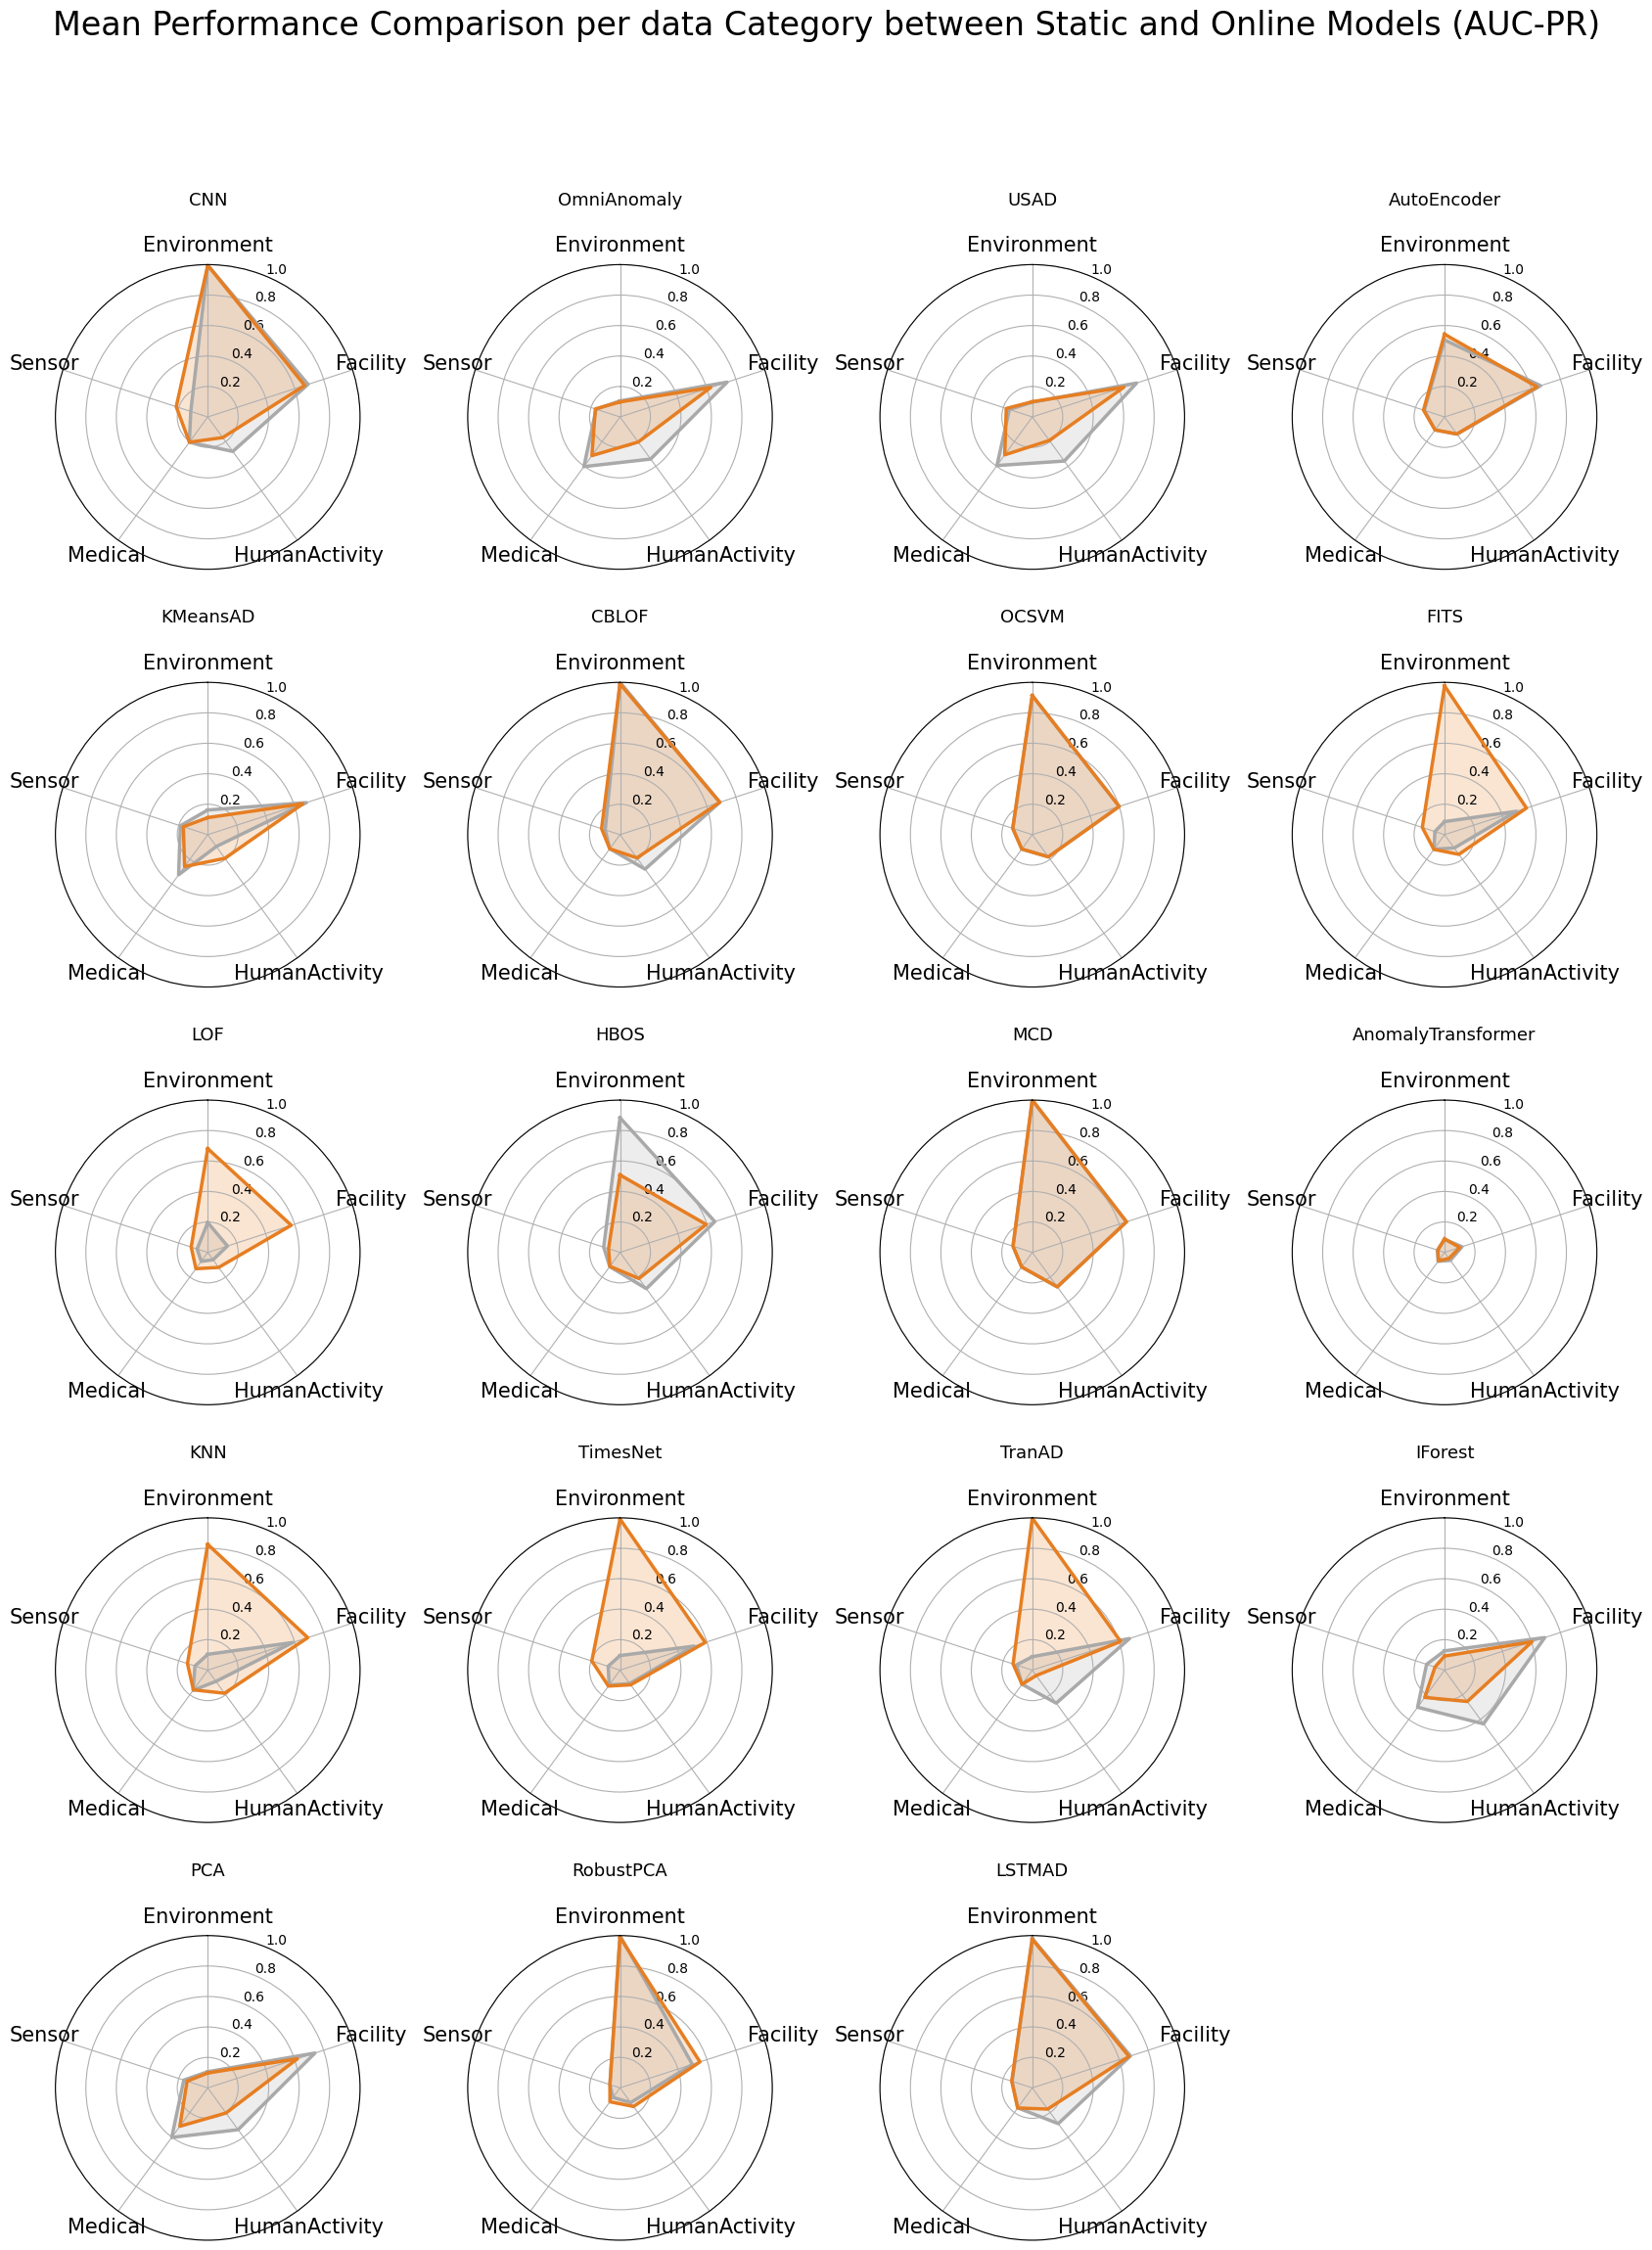

In [9]:
models_to_plot = [m for m in (Comparison_Pool) if m in df_AUC_PR_full.columns]
nrows, ncols = 5, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(17, 22), 
                         subplot_kw=dict(polar=True), 
                         constrained_layout=True)
axes = axes.flatten()

for i, model in enumerate(models_to_plot):
    if i >= len(axes): break


    spider_plot(axes[i], 
                df_ref = df_AUC_PR_off, 
                model = model, 
                COLOR_REF = "#A9A9A9",
                df_new = df_AUC_PR_on,                  
                COLOR_NEW = '#E67E22' )
    
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# legend_elements = [
#     Patch(facecolor="#A9A9A9", edgecolor='none'),
#     Patch(facecolor='#E67E22', edgecolor='none'),
# ]
# plt.legend(labels = ['Static', 'Online'],handles=legend_elements, loc='upper right', bbox_to_anchor=(1.5, 1.15), frameon=False, fontsize = 16)


plt.suptitle("Mean Performance Comparison per data Category between Static and Online Models (AUC-PR)", fontsize=24, y=1.05)

# apply_font_to_axes(plt, family_name)
plt.tight_layout()

# os.makedirs("plots/article/", exist_ok=True)
# plt.savefig("plots/article/annex_sta_on_data_category.pdf",format="pdf", 
#     bbox_inches="tight",  
#     transparent=True   
# )
plt.show()

C:\Users\d66285\AppData\Local\Temp\ipykernel_22744\3729840038.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


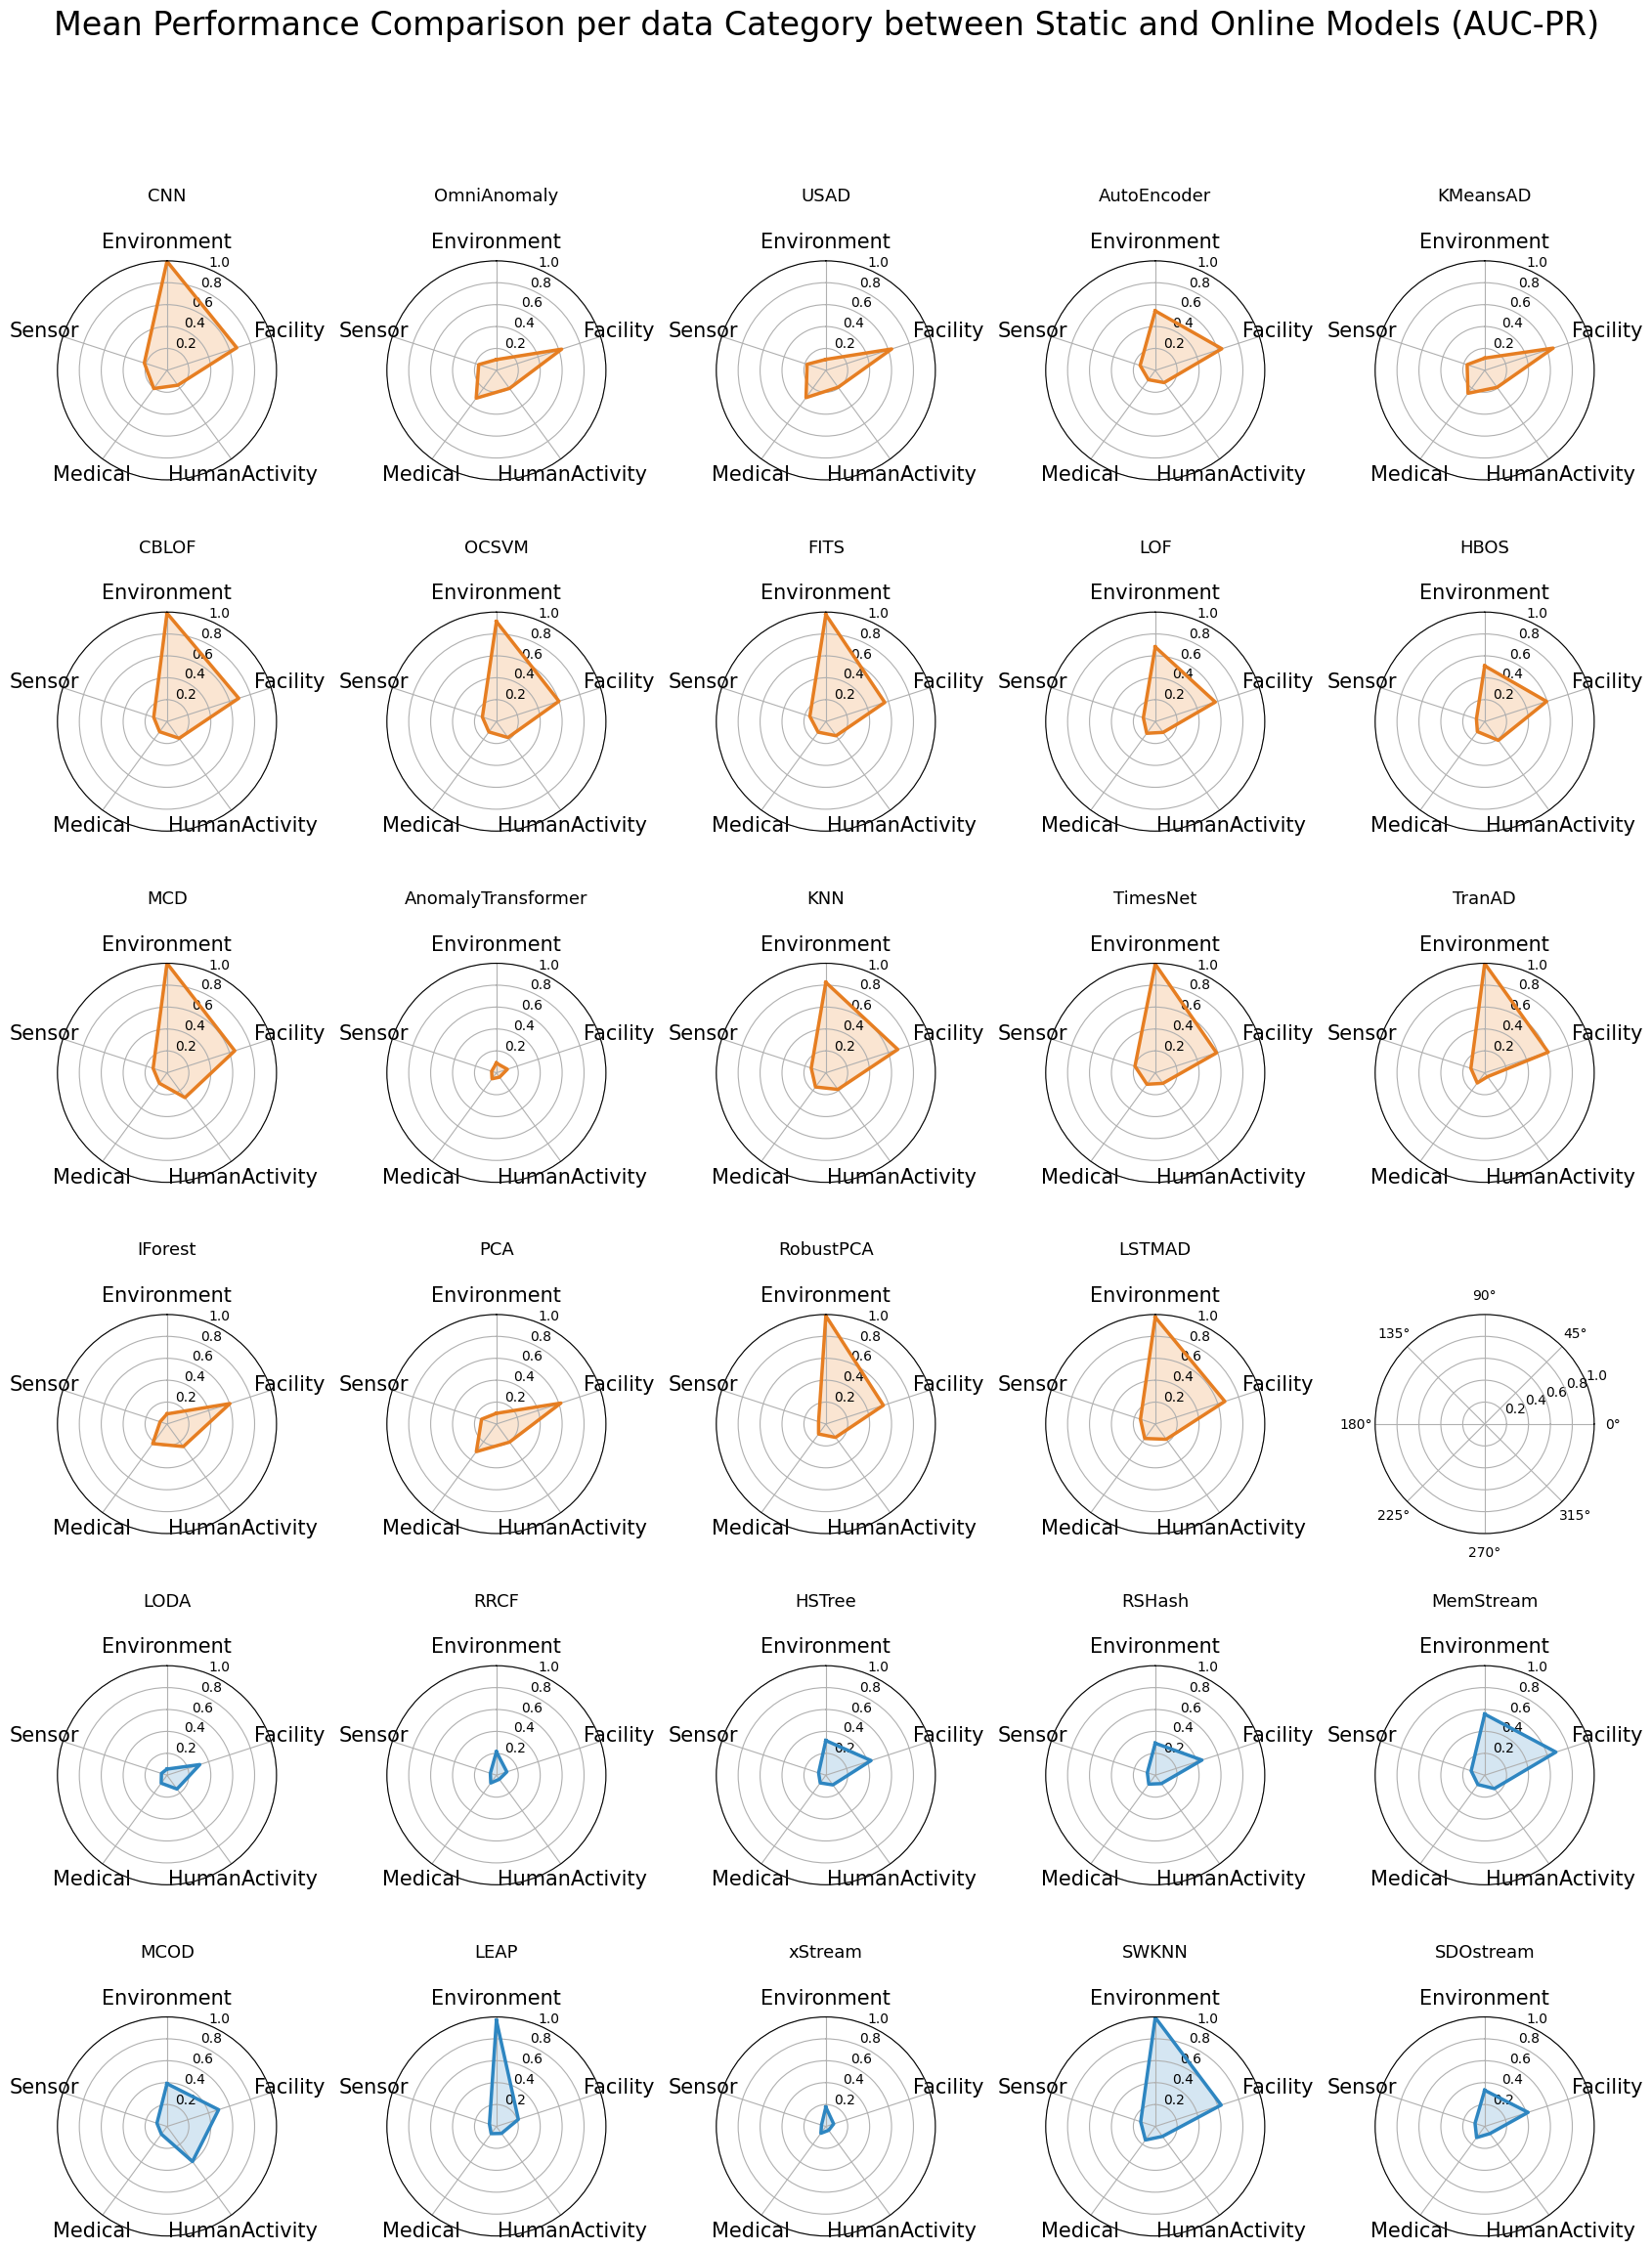

In [10]:
models_to_plot = [m for m in (Comparison_Pool + Streaming_Pool) if m in df_AUC_PR_full.columns]
nrows, ncols = 6, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(17, 22), 
                         subplot_kw=dict(polar=True), 
                         constrained_layout=True)
axes = axes.flatten()

for i, model in enumerate(models_to_plot):
    if i >= len(axes): break

    if model in Comparison_Pool:
        color = '#E67E22'
    else:
        i+=1
        color = '#2E86C1'


    spider_plot(axes[i], 
                df_ref = df_AUC_PR_full, 
                model = model, 
                COLOR_REF = color)
    


for j in range(i + 1, len(axes)):
    axes[j].axis('off')


# legend_elements = [
#     Patch(facecolor="#E67E22", edgecolor='none'),
#     Patch(facecolor='#2E86C1', edgecolor='none'),
# ]
# plt.legend(labels = ['Online', 'Streaming'],handles=legend_elements, loc='upper right', bbox_to_anchor=(1.5, 1.15), frameon=False, fontsize = 16)


plt.suptitle("Mean Performance Comparison per data Category between Static and Online Models (AUC-PR)", fontsize=24, y=1.05)

# apply_font_to_axes(plt, family_name)
plt.tight_layout()

# os.makedirs("plots/article/", exist_ok=True)
# plt.savefig("plots/article/annex_on_str_data_category.pdf",format="pdf", 
#     bbox_inches="tight",
#     transparent=True     
# )
plt.show()






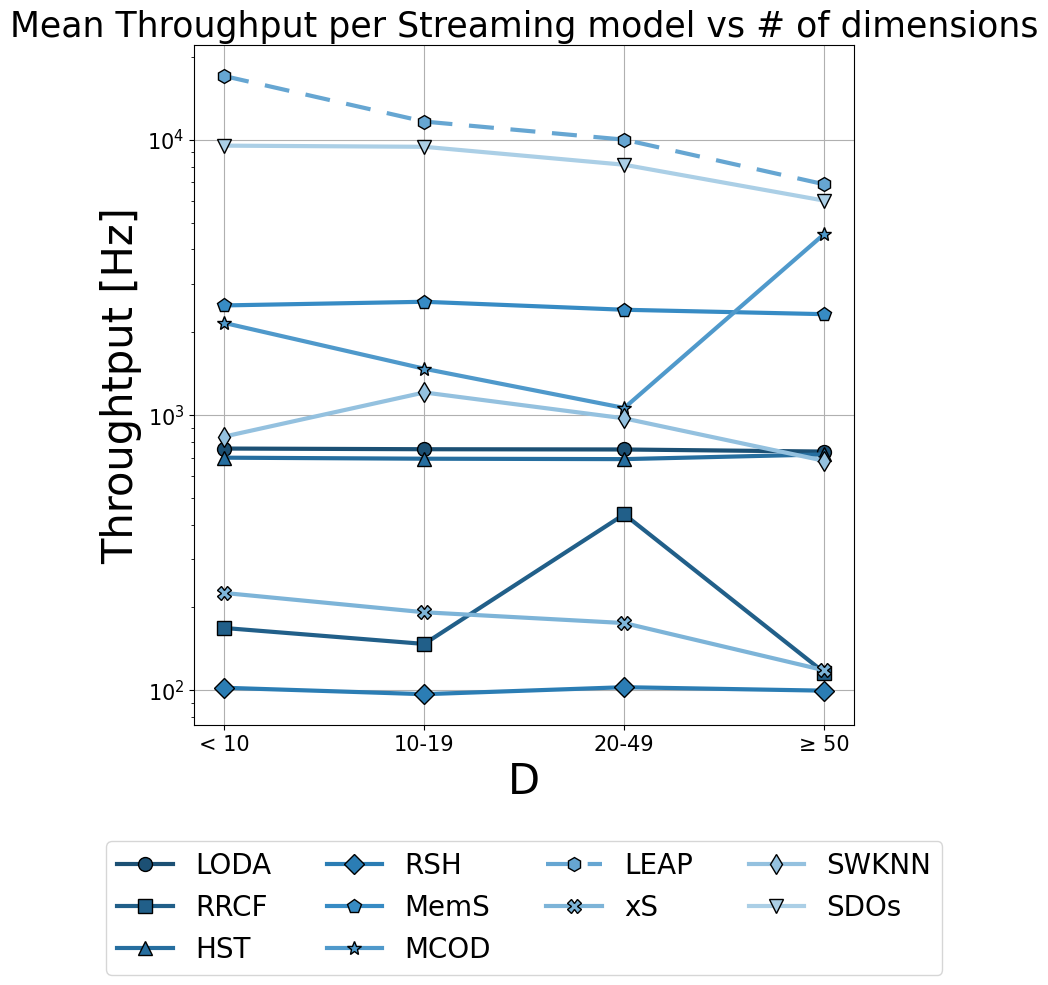

In [11]:

import pandas as pd
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import to_rgb



def generate_palette(hex_color, n, start_factor=1.4, end_factor=0.4):
    base = np.array(to_rgb(hex_color))
    colors = []
    
    factors = np.linspace(start_factor, end_factor, n)
    
    for f in factors:
        if f > 1.0:
            color = base * (2.0 - f) 
        else:
            color = base + (1 - base) * (1 - f)
        colors.append(np.clip(color, 0, 1))
    
    return colors




Study_stream = Streaming_Pool# ['LEAP', 'SDOstream', 'MemStream', 'SWKNN']
Study_online = Comparison_Pool #['RobustPCA', 'PCA', 'KNN', 'CNN']


orange_palette = generate_palette("#E67E22", len(Study_online))
blue_palette   = generate_palette("#2E86C1", len(Study_stream))

bins = [-np.inf, 10, 20, 50, np.inf]
labels = ["< 10", "10-19", "20-49", "≥ 50"]

merged_throughput_df['features_bin'] = pd.cut(
    merged_throughput_df['features'],
    bins=bins,
    labels=labels,
    right=False,          
    include_lowest=True
)

merged_throughput_df['features_bin'] = merged_throughput_df['features_bin'].cat.set_categories(labels, ordered=True)

avg_by_bin = merged_throughput_df.groupby('features_bin', observed=True).mean(numeric_only=True)

def thousands_formatter(x, pos):
    if x >= 1000:
        return f"{int(x/1000)}k"
    else:
        return str(int(x))




fig, ax = plt.subplots(figsize=(8, 10))

### TO MODIFY: Study_stream or Study_online
models = Study_stream 


display_map = {
    "OmniAnomaly": "OA",
    "AutoEncoder": "AE",
    "TimesNet": "TN",
    "RobustPCA": "RPCA",
    "AnomalyTransformer": "AT",
    "KMeansAD": "KMAD",
    "SDOstream":"SDOs",
    "MemStream": "MemS",
    "xStream" : 'xS',
    'IForest': 'IF',
    'RSHash': 'RSH',
    'HSTree': 'HST'
}
# display_labels = [display_map.get(name, name) for name in models]
# colors = cm.viridis(np.linspace(0, 1, lent()))


stream_idx = 0
online_idx = 0
model_colors = {}
all_markers = ['o', 's', '^', 'D', 'p', '*', 'h', 'X', 'd', 'v', '<', '>', '8', 'P', 'H', '+', 'x', '1', '2']

for i, model in enumerate(models):
        linestyle = '-'
        dashes = None

        marker = all_markers[i % len(all_markers)]

        if model in Streaming_Pool:
            # marker = 's'            
            model_colors[model] = blue_palette[stream_idx]
            stream_idx += 1
            if model == 'LEAP':                 
                linestyle = '--'
                dashes = (6, 4)

        else:
            # marker = 'o'             
            model_colors[model] =  orange_palette[online_idx]
            online_idx += 1

        
        line = plt.plot(
                avg_by_bin.index,
                avg_by_bin[model],
                marker=marker,
                color=model_colors[model],
                label=display_map.get(model, model),
                linewidth=3,
                markersize=10,
                linestyle=linestyle,
                markeredgecolor='black',
            )[0]

        if dashes is not None:
            line.set_dashes(dashes)


ax.set_title("Mean Throughput per Streaming model vs # of dimensions", fontsize=25)
ax.set_xlabel('D', fontsize=30)
ax.set_ylabel('Throughtput [Hz]', fontsize=30)

ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
ax.tick_params(axis='y', labelsize=15)
ax.set_yscale('log')
ax.grid(True)

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=15)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=20)

# apply_font_to_axes(ax, family_name)

plt.subplots_adjust(bottom=0.2, right=0.95)
plt.show()


In [12]:
"""
# The following code was adapted from:
# https://github.com/thedatumorg/TSB-AD/tree/main/benchmark_exp
# Original Author: Qinghua Liu
# Apache License 2.0
"""

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import operator
import math
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman
import networkx
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
import seaborn as sns

def Friedman_Nemenyi(alpha=0.05, df_perf=None):
    df_counts = pd.DataFrame({'count': df_perf.groupby(
        ['classifier_name']).size()}).reset_index()
    # Record the maximum number of datasets
    max_nb_datasets = df_counts['count'].max()
    # Create a list of classifiers
    classifiers = list(df_counts.loc[df_counts['count'] == max_nb_datasets]
                       ['classifier_name'])

    # print('classifiers: ', classifiers)

    '''
    Expected input format for friedmanchisquare is:
                Dataset1        Dataset2        Dataset3        Dataset4        Dataset5
    classifer1
    classifer2
    classifer3 
    '''

    # Compute friedman p-value
    friedman_p_value = friedmanchisquare(*(
        np.array(df_perf.loc[df_perf['classifier_name'] == c]['accuracy'])
        for c in classifiers))[1]

    # Decide whether to reject the null hypothesis
    # If p-value >= alpha: we cannot reject the null hypothesis. No statistical difference.
    if friedman_p_value >= alpha:
        print('No statistical difference...')
        return None,None,None
    # Friedman test OK
    # Prepare input for Nemenyi test
    data = []
    for c in classifiers:
        data.append(df_perf.loc[df_perf['classifier_name'] == c]['accuracy'])
    data = np.array(data, dtype=np.float64)
    # Conduct the Nemenyi post-hoc test
    # print(classifiers)
    # Order is classifiers' order
    nemenyi = posthoc_nemenyi_friedman(data.T)

    # print(nemenyi)
    
    # Original code: p_values.append((classifier_1, classifier_2, p_value, False)), True: represents there exists statistical difference
    p_values = []

    # Comparing p-values with the alpha value
    for nemenyi_indx in nemenyi.index:
        for nemenyi_columns in nemenyi.columns:
            if nemenyi_indx < nemenyi_columns:
                if nemenyi.loc[nemenyi_indx, nemenyi_columns] < alpha:
                    p_values.append((classifiers[nemenyi_indx], classifiers[nemenyi_columns], nemenyi.loc[nemenyi_indx, nemenyi_columns], True))
                else:
                    p_values.append((classifiers[nemenyi_indx], classifiers[nemenyi_columns], nemenyi.loc[nemenyi_indx, nemenyi_columns], False))
            else: continue

    # Nemenyi test OK

    m = len(classifiers)

    # Sort by classifier name then by dataset name
    sorted_df_perf = df_perf.loc[df_perf['classifier_name'].isin(classifiers)]. \
        sort_values(['classifier_name', 'dataset_name'])

    rank_data = np.array(sorted_df_perf['accuracy']).reshape(m, max_nb_datasets)

    df_ranks = pd.DataFrame(data=rank_data, index=np.sort(classifiers), columns=np.unique(sorted_df_perf['dataset_name']))

    dfff = df_ranks.rank(ascending=False)
    # compute average rank
    average_ranks = df_ranks.rank(ascending=False).mean(axis=1).sort_values(ascending=False)
    
    return p_values, average_ranks, max_nb_datasets

def graph_ranks(avranks, names, p_values, cd=None, cdmethod=None, lowv=None, highv=None,
                width=200, textspace=1, reverse=False, filename=None, highlight=None, **kwargs):

    width = width
    textspace = float(textspace)

    
    width = width
    textspace = float(textspace)
    '''l is an array of array 
        [[......]
         [......]
         [......]]; 
    n is an integer'''
    # n th column
    def nth(l, n):
        n = lloc(l, n)
        # Return n th column
        return [a[n] for a in l]
    
    '''l is an array of array 
        [[......]
         [......]
         [......]]; 
    n is an integer'''
    # return an integer, count from front or from back.
    def lloc(l, n):
        if n < 0:
            return len(l[0]) + n
        else:
            return n
    # lr is an array of integers
    # Maximum range start from all zeros. Returns an iterable element of tuple.
    def mxrange(lr):
        # If nothing in the array
        if not len(lr):
            yield ()
        else:
            index = lr[0]
            # Check whether index is an integer.
            if isinstance(index, int):
                index = [index]
            # *index: index must be an iterable []
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    # Form a tuple, and generate an iterable value
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    nnames = names
    ssums = sums
    # lowv: low value
    if lowv is None:
        '''int(math.floor(min(ssums))): select the minimum value in ssums and take floor.
           Then compare with 1 to see which one is the minimum.'''
        lowv = min(1, int(math.floor(min(ssums))))
    # highv: high value
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4
    # how many algorithms
    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace
    
    # Position of rank
    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        # Set up the format
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    cline += distanceh

    # set up the formats
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant + 2

    # matplotlib figure format setup
    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_axis_off()

    hf = 1. / height
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    # Line plots
    def line(l, color='k', **kwargs):
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    # Add text to the plot
    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05
    linewidth = 2.0
    linewidth_sign = 4.0

    tick = None

    # [lowv, highv], step size is 0.5
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        # If a is an integer
        if a == int(a):
            tick = bigtick
        # Plot a line
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=0.7)

    # Add text to the plot, only for integer value
    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom", size=16)

    k = len(ssums)

    def filter_names(name):
        return name

    space_between_names = 0.24
    highlight_color = "#2E86C1" # La couleur demandée

    # Format pour la première moitié des algorithmes
    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
              linewidth=linewidth)

        # CHANGEMENT ICI : Condition pour la couleur
        color = highlight_color if (highlight and nnames[i] in highlight) else '#E67E22'
        
        text(textspace - 0.2, chei, filter_names(nnames[i]), color=color, ha="right", va="center", size=16)

    # Format pour la seconde moitié des algorithmes
    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
              linewidth=linewidth)

        # CHANGEMENT ICI : Condition pour la couleur
        color = highlight_color if (highlight and nnames[i] in highlight) else '#E67E22'
        
        text(textspace + scalewidth + 0.2, chei, filter_names(nnames[i]), color=color, ha="left", va="center", size=16)
        

    # no-significance lines
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line([(rankpos(ssums[l]) - side, start),
                  (rankpos(ssums[r]) + side, start)],
                 linewidth=linewidth_sign)
            start += height
            
    start = cline + 0.2
    side = -0.02
    height = 0.1


    #Generate cliques and plot a line to connect elements in cliques    
    cliques = form_cliques(p_values, nnames)
    i = 1
    achieved_half = False
    # Plot a line to connect elements in cliques
    for clq in cliques:
        if len(clq) == 1:
            continue
        min_idx = np.array(clq).min()
        max_idx = np.array(clq).max()
        if min_idx >= len(nnames) / 2 and achieved_half == False:
            start = cline + 0.25
            achieved_half = True
        # Test
        # print("ssums[min_idx]: {}; ssums[max_idx]: {}".format(ssums[min_idx], ssums[max_idx]))
        line([(rankpos(ssums[min_idx]) - side, start),
              (rankpos(ssums[max_idx]) + side, start)],
             linewidth=linewidth_sign)
        start += height

def form_cliques(p_values, nnames):
    m = len(nnames)
    g_data = np.zeros((m, m), dtype=np.int64)
    for p in p_values:
        if p[3] == False:
            i = np.where(nnames == p[0])[0][0]
            j = np.where(nnames == p[1])[0][0]
            min_i = min(i, j)
            max_j = max(i, j)
            g_data[min_i, max_j] = 1
    g = networkx.Graph(g_data)

    #Test
    # print("p_values in form_cliques:\n{}".format(p_values))
    # print("g_data:\n{}".format(g_data))

    # Returns all maximal cliques in an undirected graph.
    return networkx.find_cliques(g)

ranking: ['CNN', 'KNN', 'OmniAnomaly', 'LSTMAD', 'USAD', 'SWKNN', 'KMeansAD', 'OCSVM', 'LOF', 'PCA']


C:\Users\d66285\AppData\Local\Temp\ipykernel_22744\3555469024.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


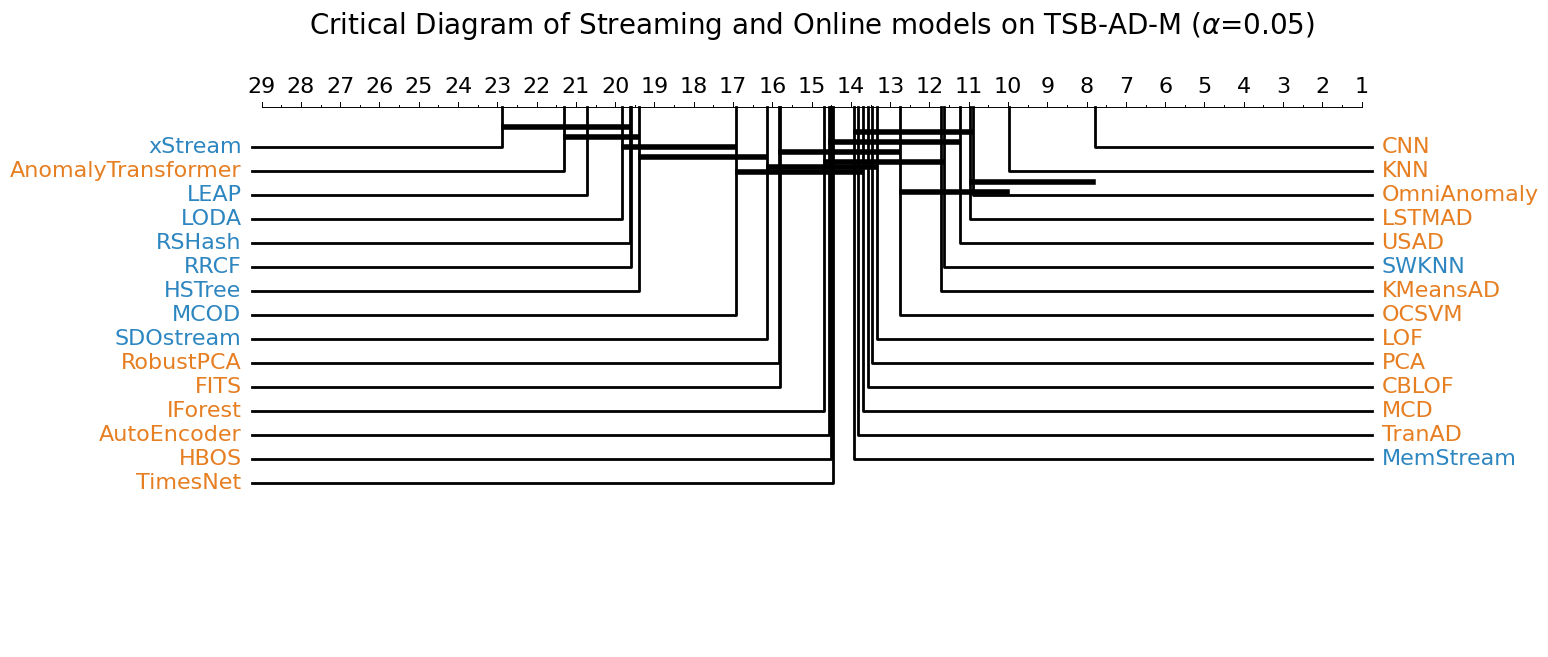

In [13]:
df_filter = df_AUC_PR_full[Comparison_Pool + Streaming_Pool +['file']]


eval_list = []
for index, row in df_filter.iterrows():
    for method in Comparison_Pool + Streaming_Pool:
        eval_list.append([method, row['file'], row[method]])
eval_df = pd.DataFrame(eval_list, columns=['classifier_name', 'dataset_name', 'accuracy'])
p_values, average_ranks, _ = Friedman_Nemenyi(df_perf=eval_df, alpha=0.05)
ranking = average_ranks.keys().to_list()[::-1]

graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
            cd=None, reverse=True, width=14, textspace=1.5, highlight=Streaming_Pool)
print('ranking:', ranking[:10])
plt.title("Critical Diagram of Streaming and Online models on TSB-AD-M ({}=0.05)".format(r'$\alpha$'),fontsize=20)
plt.tight_layout()
plt.show()

ranking: ['MCD', 'TranAD', 'CNN', 'SWKNN', 'TimesNet', 'KNN', 'CBLOF', 'OCSVM', 'LSTMAD', 'RobustPCA']


C:\Users\d66285\AppData\Local\Temp\ipykernel_22744\4201246085.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


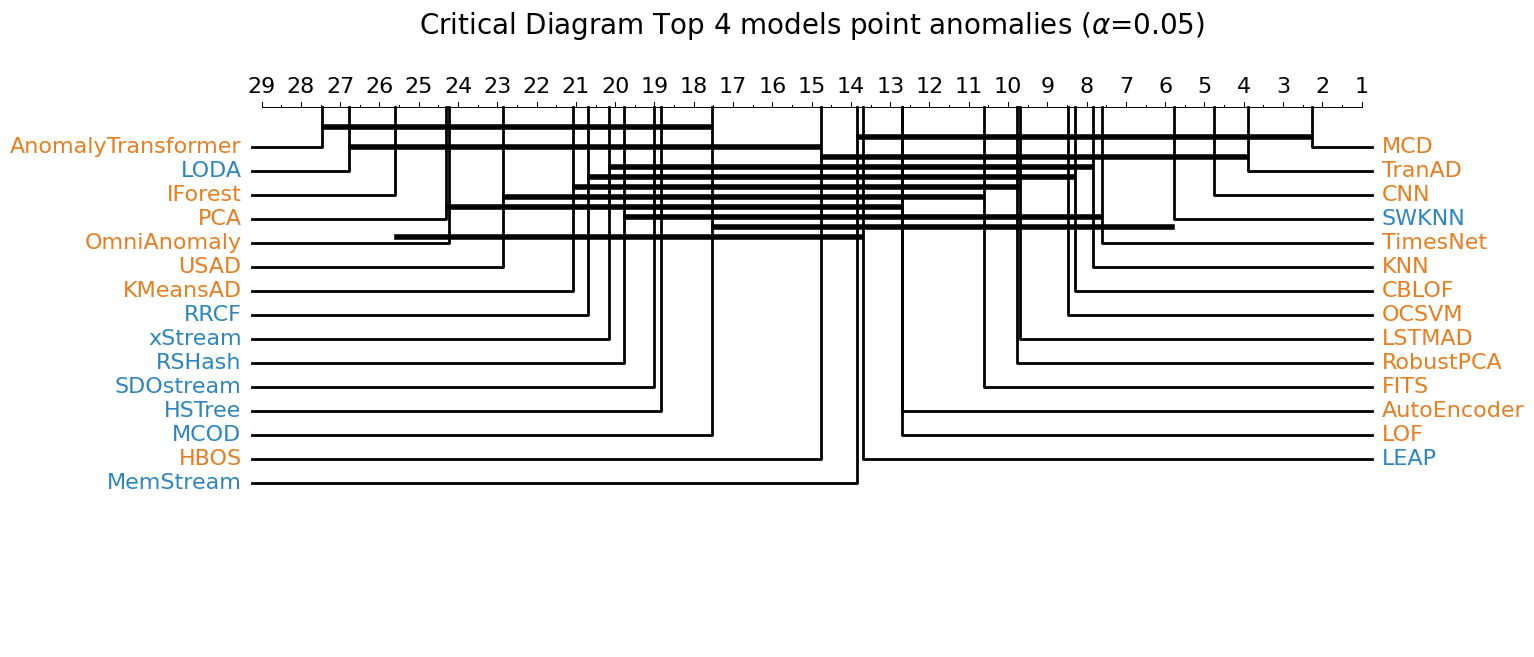

In [14]:
point_list = ['115_PSM_id_1_Facility_tr_50000_1st_129872.csv', '116_TAO_id_1_Environment_tr_500_1st_3.csv', '117_TAO_id_2_Environment_tr_500_1st_1.csv', 
              '118_TAO_id_3_Environment_tr_500_1st_7.csv', '119_TAO_id_4_Environment_tr_500_1st_1.csv', '121_TAO_id_6_Environment_tr_500_1st_7.csv', 
              '122_TAO_id_7_Environment_tr_500_1st_19.csv', '123_TAO_id_8_Environment_tr_500_1st_62.csv', '124_TAO_id_9_Environment_tr_500_1st_1.csv', 
              '125_TAO_id_10_Environment_tr_500_1st_9.csv', '127_TAO_id_12_Environment_tr_500_1st_24.csv', '128_TAO_id_13_Environment_tr_500_1st_7.csv', 
              '137_CreditCard_id_1_Finance_tr_500_1st_541.csv']

df_filter = df_AUC_PR_full[df_AUC_PR_full['file'].isin(point_list)][Comparison_Pool +Streaming_Pool+ ['file']]

eval_list = []
for index, row in df_filter.iterrows():
    for method in Comparison_Pool + Streaming_Pool:
        eval_list.append([method, row['file'], row[method]])
eval_df = pd.DataFrame(eval_list, columns=['classifier_name', 'dataset_name', 'accuracy'])
p_values, average_ranks, _ = Friedman_Nemenyi(df_perf=eval_df, alpha=0.05)
ranking = average_ranks.keys().to_list()[::-1]

graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
            cd=None, reverse=True, width=14, textspace=1.5, highlight=Streaming_Pool)
print('ranking:', ranking[:10])
plt.title("Critical Diagram Top 4 models point anomalies ({}=0.05)".format(r'$\alpha$'),fontsize=20)
plt.tight_layout()
plt.show()